In [ ]:
# Executes PCA on the covariance matrix of time series of selected tickers from the SP500
# during the specified training interval,
# generates the corresponding returns of the portfolios of each principal component (principal portfolios),
# then tests the performance against non-reduced portfolios over another specified testing time series.
# Credits to prof. Rotondi from the Data Driven Investments class
# Andrea, Bocconi University

import numpy as np, pandas as pd
import yfinance as yf
from datetime import datetime
from scipy.optimize import minimize
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale, normalize
import matplotlib.pyplot as plt
import requests
import random
from dateutil.relativedelta import relativedelta
from datetime import date
import pytz
from time import sleep
from tqdm.notebook import tqdm
from google.colab import files

# Select n tickers from the SP500 ([1,500])
first_tickers = 100

# If ran = True, tickers will be selected randomly
# If short_term = True, t_int data will be gathered for the past two months, otherwise daily for the specified interval
# t_int selects the time interval (“5m”, “15m”, “30m”, “60m”) for short term analysis
# 1h data ('60m') is available for the last 2 years, timeframe ([0,2]) selects the number of past years to analyze
# percentage_training is used to split the dataset between training and testing
ran = True
short_term = True
t_int = '60m'
timeframe = 2 # Only active when t_int = 60m
percentage_training = 0.7
variance_threshold = 0.75
clean = True # Drop columns with NaNs if True, fill before if False (more accurate but discards many tickers)

# Define a starting/ending point for long term analysis (when short_term = False)
myStart = datetime(2013, 6 , 1)
myEnd = datetime(2023, 6, 1)

# The dictionary with the colors is at the end of the notebook, please run the last block first
# Color scheme
plt.style.use('ggplot')

In [ ]:
# Download and clean SP500 tickers list
utc = pytz.UTC
header = {
  "User-Agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.75 Safari/537.36",
  "X-Requested-With": "XMLHttpRequest"
}
r = requests.get('https://www.slickcharts.com/sp500', headers=header)
sp500_by_weight = pd.read_html(r.text)[0]['Symbol'].tolist()
if ran == True:
  tickers2 = random.sample(sp500_by_weight, first_tickers)
else:
  tickers2 = sp500_by_weight[0:first_tickers]

for tick in tqdm(tickers2):
  data2 = yf.download(tick, start = myStart, end = myEnd, progress=False)
  if data2['Adj Close'].empty or data2['Adj Close'].isnull().values.any():
      tickers2.remove(tick)

# These tickers cause problems with the datetime module
if 'PGR' in tickers2: tickers2.remove('PGR')
if 'EXC' in tickers2: tickers2.remove('EXC')
if 'RCL' in tickers2: tickers2.remove('RCL')
if 'CMA' in tickers2: tickers2.remove('CMA')

# These tickers produce NaNs in the covariance matrix (?)
if 'FI' in tickers2: tickers2.remove('FI')
if 'COR' in tickers2: tickers2.remove('COR')
if 'KVUE' in tickers2: tickers2.remove('KVUE')
if 'RVTY' in tickers2: tickers2.remove('RVTY')
if 'EG' in tickers2: tickers2.remove('EG')
if 'DD' in tickers2: tickers2.remove('DD')


  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
# Download time series for each ticker
prices = pd.DataFrame()

if ran == True:
  sampl = "100 random"
elif first_tickers == 500:
  sampl = "SP500"
else:
  sampl = "SP100"
if t_int == '60m':
  horizon = int(timeframe * 360)
  t_hor = '2 years'
  t_freq = 'hourly'
else:
  horizon = 60

if short_term == True:
  if t_int != '60m':
    t_hor = '2 months'
    t_freq = t_int
  today = (datetime.today() - relativedelta(days=2))#.date() #.replace(hour=9, minute=31, second=0, microsecond=0)
  beginning = (datetime.today() - relativedelta(days=horizon-2))#.date() #.replace(hour=9, minute=30, second=0, microsecond=0)
  when_training = (datetime.today() - relativedelta(days=(int(horizon*(1-percentage_training)))))#.date() #replace(hour=9, minute=30, second=0, microsecond=0)
  when_testing = (datetime.today() - relativedelta(days=(int(horizon*(1-percentage_training))-1)))#.date() #.replace(hour=9, minute=30, second=0, microsecond=0)

  if t_int == '5m':  # Adjustment for the datetime module
    today = utc.localize(today)
    beginning = utc.localize(beginning)
    when_training = utc.localize(when_training)
    when_testing = utc.localize(when_testing)

  for tick in tqdm(tickers2):
    data = yf.download(tick, start = beginning, end = today, interval = t_int, progress=False)
    prices = pd.concat([prices, data['Adj Close']], axis=1)
    prices.rename(columns = {'Adj Close':tick}, inplace = True)

  prices_clean = pd.DataFrame()
  if clean == True:
    prices_clean = prices.dropna(axis=1)
  else:
    prices_clean = prices.fillna(method = 'bfill')
  prices = prices_clean

  # 13 Week T Bill as risk free rate, approximation to align the datasets
  # (RF doesnt change much in 60 days)
  data = yf.download('^IRX', start=beginning, end=today, interval=t_int, progress=False)
  rf_series = pd.DataFrame(data['Adj Close'] / 100).rename(columns={'Adj Close':'RF'})
  if rf_series.shape[0]-prices.shape[0] >= 0:
    rf_series = rf_series.iloc[:prices.shape[0]-rf_series.shape[0]]
  else:
    add = np.minimum(np.arange(prices.shape[0]), len(rf_series) - 1)
    rf_series = rf_series.iloc[add]
  prices_index = prices.index.tolist()
  rf_series.reset_index(drop=True, inplace=True)
  rf_series = rf_series.set_index(pd.Index(prices_index))
  rf = rf_series.mean()

  # SP500 and SP100 for benchmark depending on data to be analyzed
  # (if random tickers or large number, considers SP500)
  if ran == True or len(tickers2) > 100:
    benchmark = pd.DataFrame(yf.download('^GSPC', start=beginning, end=today,interval=t_int, \
                                         progress=False)['Adj Close']).rename(columns={'Adj Close':'SP500'})
    bmk = "SP500"
  else:
    benchmark = pd.DataFrame(yf.download('^OEX', start=beginning, end=today,interval=t_int, \
                                         progress=False)['Adj Close']).rename(columns={'Adj Close':'SP100'})
    bmk = "SP100"

  # Split dataframes into training and testing
  prices_training = prices[beginning : when_training]
  prices_test = prices[when_testing : today]
  rf_series_training_wonk = rf_series[beginning : when_training]
  rf_series_test_wonk = rf_series[when_testing : today]
  benchmark_training_wonk = benchmark[beginning : when_training]
  benchmark_test_wonk = benchmark[when_testing : today]
  # Set annualization factor
  ann_fact =  250 * 6.5 * 60 / int(t_int[:-1])
else:
  t_hor = '10 years'
  t_freq = 'daily'
  diff = myEnd - myStart
  when_training = myStart + relativedelta(days=int(diff.days*percentage_training))
  when_testing = when_training + relativedelta(days=1)
  for tick in tqdm(tickers2):
    data = yf.download(tick, start = myStart, end = myEnd, progress=False)
    prices = pd.concat([prices, data['Adj Close']], axis=1)
    prices.rename(columns = {'Adj Close':tick}, inplace=True)
  prices_clean = pd.DataFrame()
  if clean == True:
    prices_clean = prices.dropna(axis=1)
  else:
    prices_clean = prices.fillna(method = 'bfill')
  prices = prices_clean

  # 13 Week T Bill as risk free rate
  data = yf.download('^IRX', start = myStart, end = myEnd, progress=False)
  rf_series = pd.DataFrame(data['Adj Close'] / 100).rename(columns = {'Adj Close':'RF'})
  rf = rf_series.mean()
  # SP500 or SP100 for benchmark
  if ran == True or len(tickers2) > 100:
    benchmark = pd.DataFrame(yf.download('^GSPC', start=myStart, end=myEnd, \
                                         progress=False)['Adj Close']).rename(columns={'Adj Close':'SP500'})
    bmk = "SP500"
  else:
    benchmark = pd.DataFrame(yf.download('^OEX', start=myStart, end=myEnd, \
                                         progress=False)['Adj Close']).rename(columns={'Adj Close':'SP100'})
    bmk = "SP100"
  # Split dataframes into training and testing
  prices_training = prices[myStart : when_training]
  prices_test = prices[when_testing : myEnd]
  rf_series_training_wonk = rf_series[myStart : when_training]
  rf_series_test_wonk = rf_series[when_testing : myEnd]
  benchmark_training_wonk = benchmark[myStart : when_training]
  benchmark_test_wonk = benchmark[when_testing : myEnd]
  # Set annualization factor
  ann_fact = 250

tickers2 = prices_training.columns.values.tolist()
print(str(len(tickers2)) + ' tickers in original space: ' + str(tickers2))


  0%|          | 0/94 [00:00<?, ?it/s]

83 tickers in original space: ['AXP', 'AOS', 'PCAR', 'PRU', 'HES', 'NTRS', 'PM', 'FOX', 'BA', 'VFC', 'ABBV', 'MTCH', 'GE', 'LYV', 'XYL', 'EIX', 'SYK', 'SRE', 'FDS', 'PAYX', 'MAS', 'UPS', 'MOS', 'HPE', 'DPZ', 'MKTX', 'BXP', 'PAYC', 'CSGP', 'ITW', 'DTE', 'CMCSA', 'BBY', 'WST', 'ODFL', 'NUE', 'MMC', 'IFF', 'EW', 'WDC', 'CE', 'DAL', 'FRT', 'EVRG', 'ANSS', 'AXON', 'ZTS', 'APD', 'JCI', 'TAP', 'ADM', 'NDSN', 'NXPI', 'RTX', 'NVR', 'RSG', 'BDX', 'PODD', 'CAH', 'CZR', 'CAG', 'IDXX', 'F', 'MS', 'PH', 'CPRT', 'HUM', 'WMT', 'SBUX', 'ADBE', 'MGM', 'MTB', 'HST', 'CARR', 'EMR', 'EQIX', 'CDAY', 'PPL', 'INCY', 'IRM', 'KLAC', 'HON', 'VICI']


<Axes: >

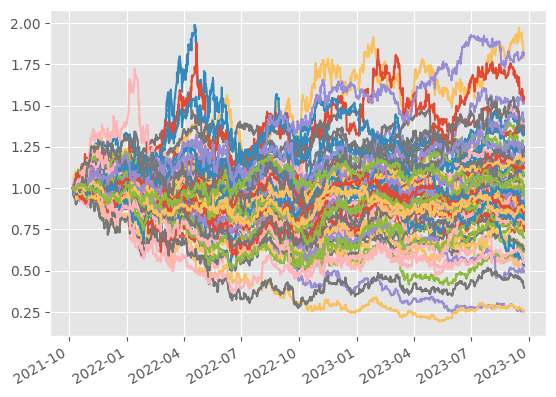

In [ ]:
(prices / prices.iloc[0]).plot(legend=False)  # Check the dataset

In [ ]:
def getReturns(prices_fct):
  return (prices_fct/prices_fct.shift(1))[1:] - 1

def getMoments(prices_fct):
  returns_fct = getReturns(prices_fct)
  mu_fct = returns_fct.mean() * ann_fact
  cov_fct = returns_fct.cov() * ann_fact
  return mu_fct, cov_fct

def getMoments_returns(returns_fct):
  mu_fct = returns_fct.mean()
  cov_fct = returns_fct.cov()
  return mu_fct, cov_fct

def getMoments_returns_ann(returns_fct):
  mu_fct = returns_fct.mean() * ann_fact
  cov_fct = returns_fct.cov() * ann_fact
  return mu_fct, cov_fct

def ptf_stats(weights_fct, mu_fct, cov_fct, rf_fct):
  ptf_mu_fct = np.dot(weights_fct.T,mu_fct)
  ptf_var_fct = np.dot(np.dot(weights_fct.T,cov_fct),weights_fct)
  ptf_std_fct = np.sqrt(ptf_var_fct)
  ptf_SR_fct = (ptf_mu_fct - rf_fct)/ptf_std_fct
  return ptf_mu_fct, ptf_var_fct, ptf_SR_fct

def objFct(w, cov):
  obj = np.dot(np.dot(w.T,cov),w)
  return obj

# in the following function, the optimal argument flag refers to
# flag = 1 --> minimum variance portfolio (for which you don't need mu)
# flag = 2 --> max Sharpe Ratio portfolio (for which you DO need mu)

# shortSelling constraint == 1 means that there is a constraint on short-selling

def optPortNum(cov, mu = None, flag = 1, shortSelling = False):
  N = cov.shape[0]

  if flag == 1:
    a = np.ones(shape=(N,1))
  elif flag == 2:
    a = mu

  if shortSelling == True:
    bnds = tuple( (0,1) for x in range(N) )
  else:
    bnds = None

  # I had to modify the initial guess because it would say that the vector was more than 1D ???
  out = minimize(objFct, (np.ones(shape=(N,1))/N).flatten(), args = cov, bounds = bnds, \
                 constraints = ({'type': 'eq', 'fun': lambda w: 1-np.dot(w.T,a)}) )
  if out['success']:
    wstar = out['x']
  else:
    wstar = None

  return wstar


In [ ]:
# Number of principal components to keep
# if > len(tickers2), it's going to be the components necessary
# to explain the variance specified
n_components = len(tickers2)
var_threshold = variance_threshold


# Get the returns for the tickers, RF and SP500 and align
returns = getReturns(prices)
returns_training = getReturns(prices_training)
returns_test = getReturns(prices_test)
rf_series_training = rf_series_training_wonk.iloc[1:]
rf_series_test = rf_series_test_wonk.iloc[1:]
benchmark_training = getReturns(benchmark_training_wonk)
benchmark_test = getReturns(benchmark_test_wonk)
# Normalize returns
returns_training_normed = (returns_training - returns_training.mean()) / returns_training.std()
returns_test_normed = (returns_test - returns_test.mean()) / returns_test.std()

# Perform PCA on the normed covariance matrix
mu_training_normed, cov_training_normed = getMoments_returns(returns_training_normed)
pca = PCA(n_components)
pca.fit(cov_training_normed.to_numpy())
loadings_full = pd.DataFrame(pca.components_.T, columns = tickers2, index = tickers2)

# If using the explained variance method
if n_components > len(tickers2)-1:
  var_explained = np.cumsum(pca.explained_variance_ratio_)
  necessary_components = np.where(np.logical_not(var_explained < var_threshold))[0][0] + 1
  print(str(necessary_components) + ' components necessary to explain ' \
        + str(var_threshold * 100) + '% of the variance')

  k_components = range(1, necessary_components + 1)
  k_components = ["PC " + str(x) for x in k_components]
  n_components = necessary_components

  pca = PCA(necessary_components)
  pca.fit(cov_training_normed.to_numpy())
  loadings = pd.DataFrame(pca.components_.T, columns = k_components, index = tickers2)
else:
  # Principal components headers
  k_components = range(1, n_components + 1)
  k_components = ["PC " + str(x) for x in k_components]

  loadings = pd.DataFrame(pca.components_.T, columns = k_components, index = tickers2)

# Normalize the weights (loadings) so they sum up to 1
sum = loadings.sum(axis=0)
w_pc = loadings.div(sum)
sum_full = loadings_full.sum(axis=0)
w_pc_full = loadings_full.div(sum_full)

expl_var = pca.explained_variance_ratio_

# Get the returns of each principal portfolio
returns_pc = returns.dot(w_pc)
returns_training_pc = returns_training.dot(w_pc)
returns_test_pc = returns_test.dot(w_pc)
returns_training_pc_full = returns_training.dot(w_pc_full)
returns_test_pc_full = returns_test.dot(w_pc_full)

4 components necessary to explain 75.0% of the variance


<Axes: title={'center': 'Composition of principal components'}>

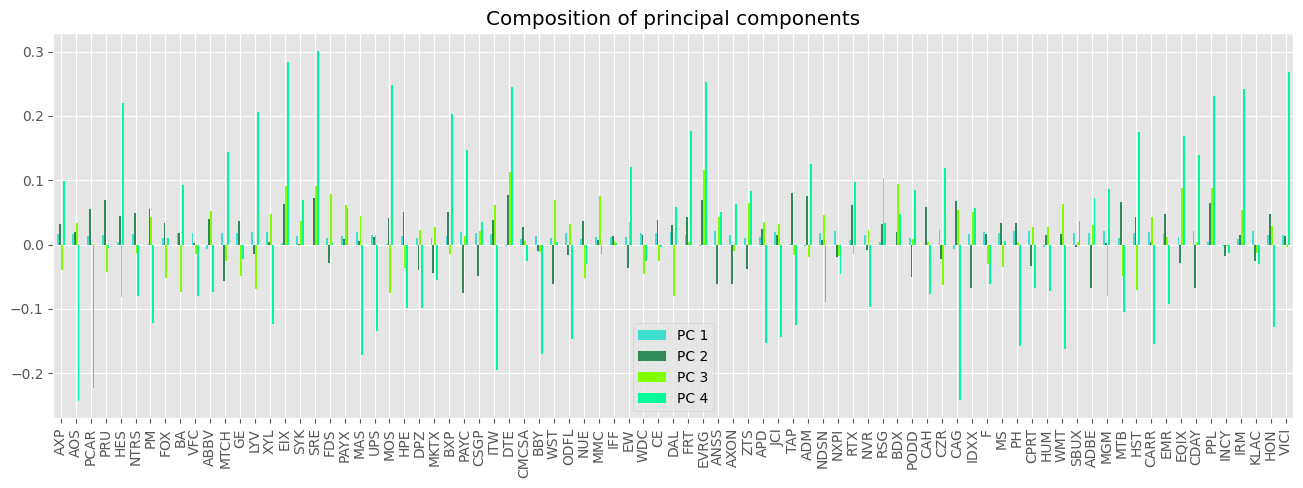

In [ ]:
col = list(random.sample(list(cnames.values()), returns_pc.shape[1]))
w_pc.plot.bar(figsize = (5 + int(len(tickers2)/7),5), color=col, title="Composition of principal components")

<Axes: title={'center': 'Explained variance by PC'}>

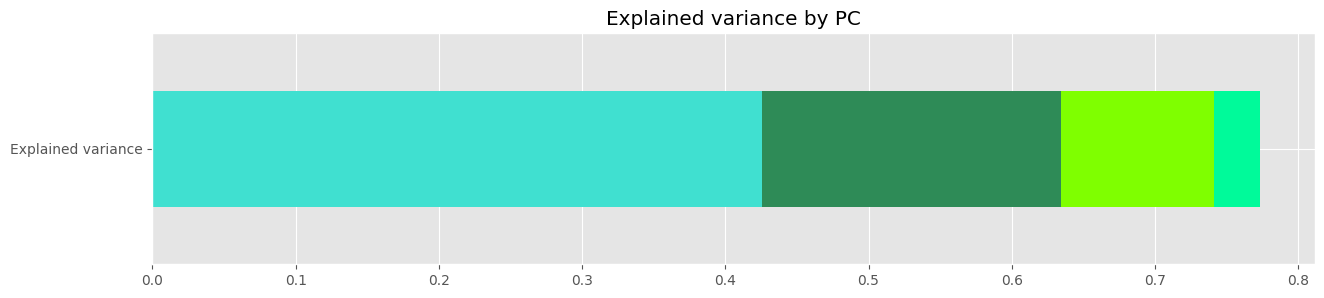

In [ ]:
pd.DataFrame(expl_var, index=k_components,\
             columns=["Explained variance"]).T.plot.barh(color=col, stacked=True, figsize=(15,3), legend=False, title="Explained variance by PC")


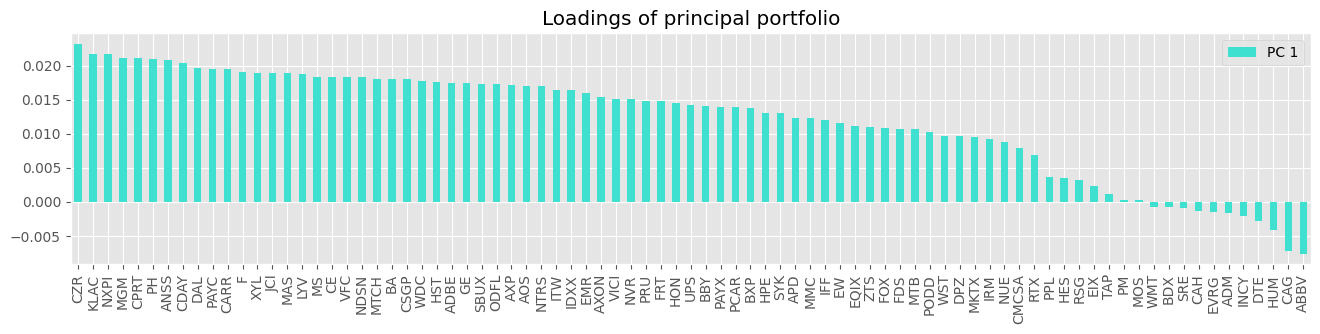

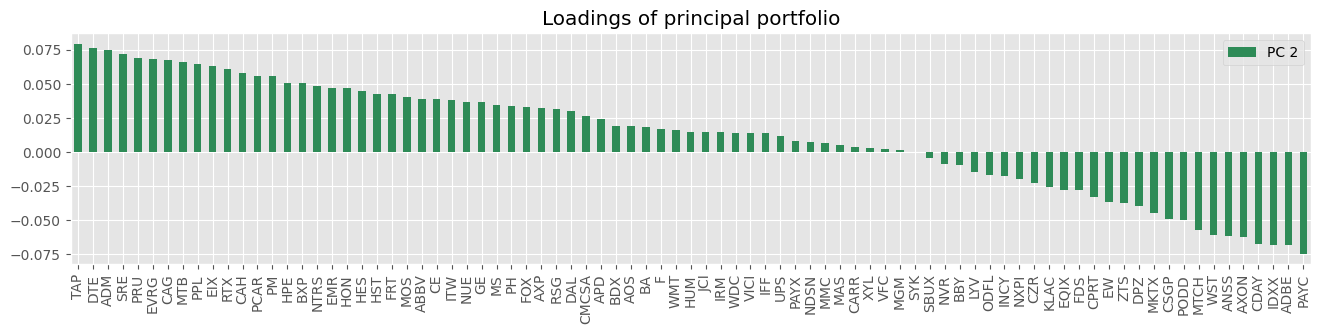

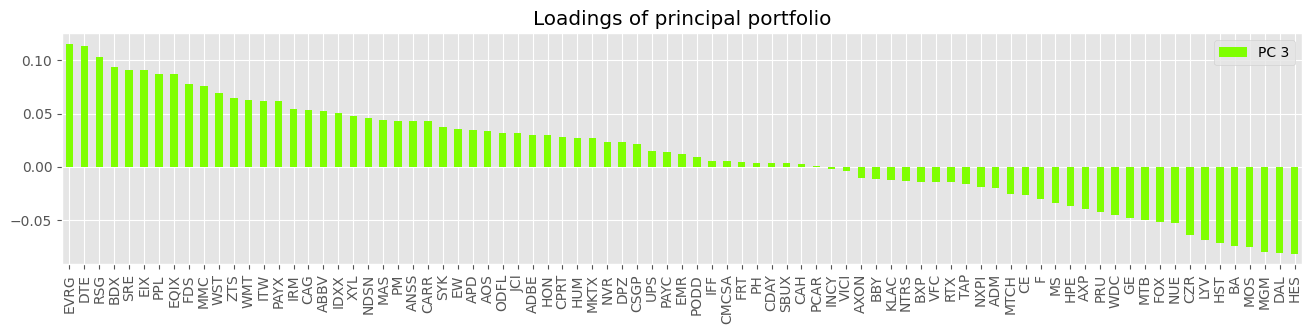

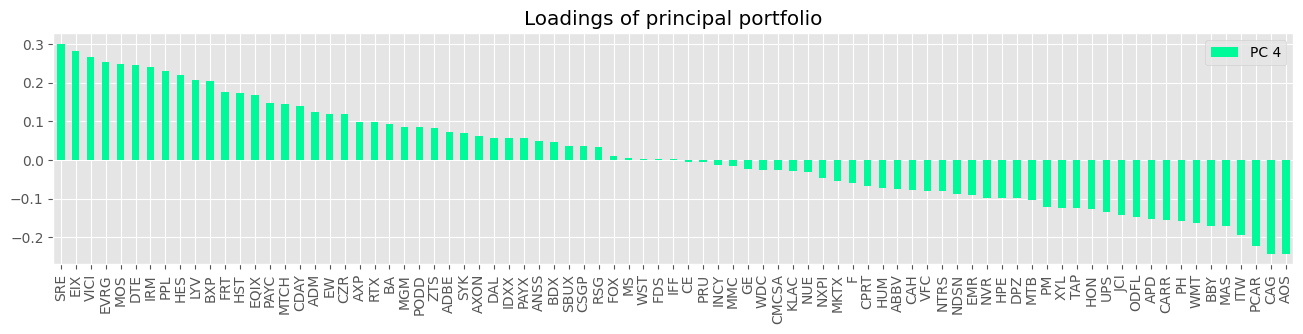

In [ ]:
# Sort principal portfolios by weight and plot them
unsorted_pp = {}
for x in range(1, returns_test_pc.shape[1]+1):
  unsorted_pp["PC {0}".format(x)] = pd.DataFrame(w_pc['PC '+str(x)])

sorted_pp = unsorted_pp

for x in sorted_pp:
  sorted_pp[x] = sorted_pp[x].sort_values(by=x, ascending=False)
for x in sorted_pp:
  sorted_pp[x].plot.bar(color=col[int(x[-1])-1], figsize = (5 + int(len(tickers2)/7),3), \
                        title="Loadings of principal portfolio")


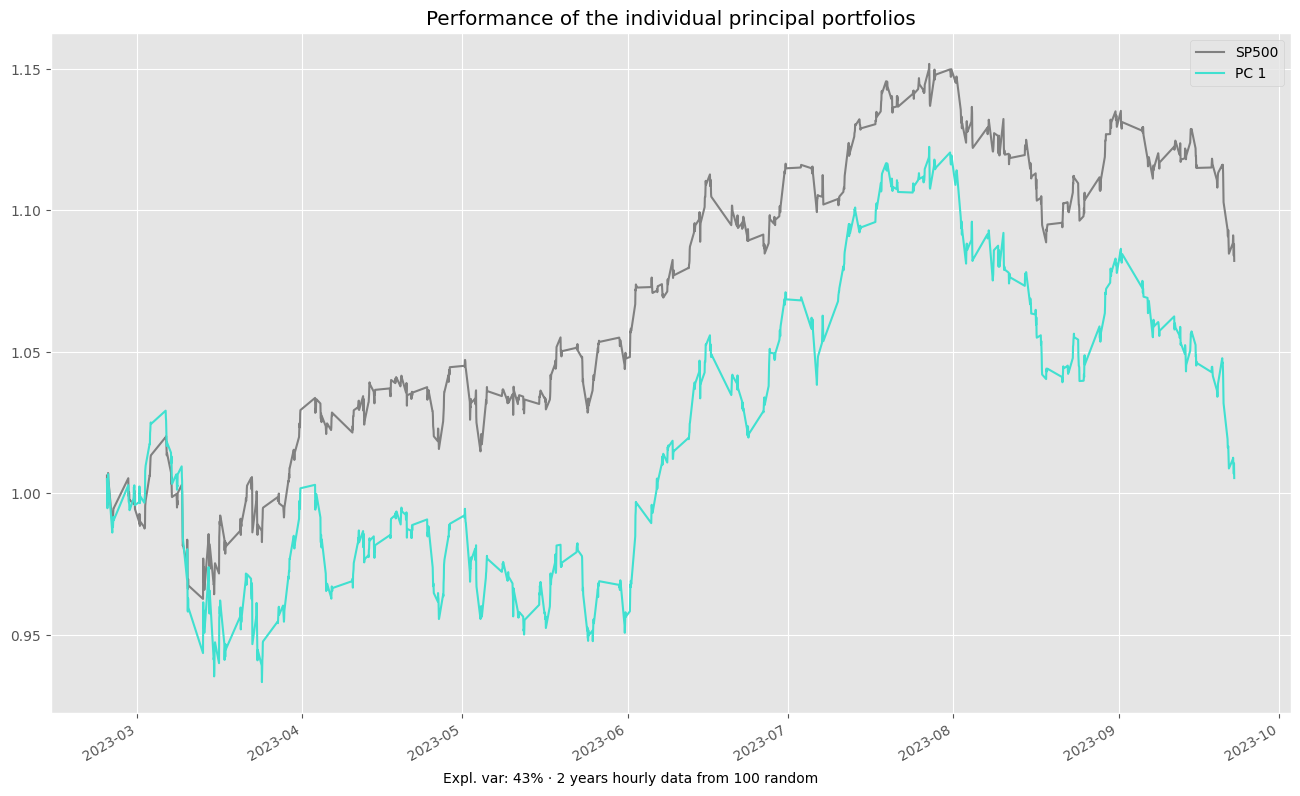

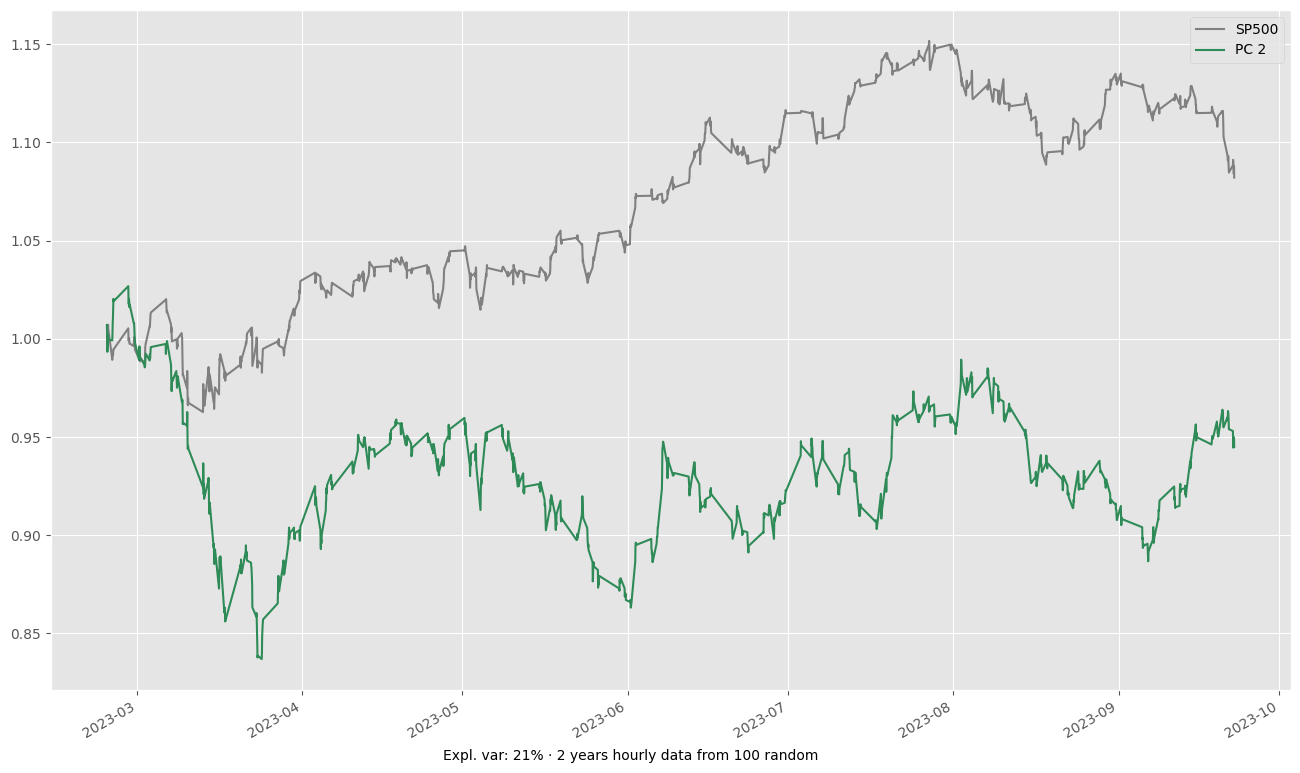

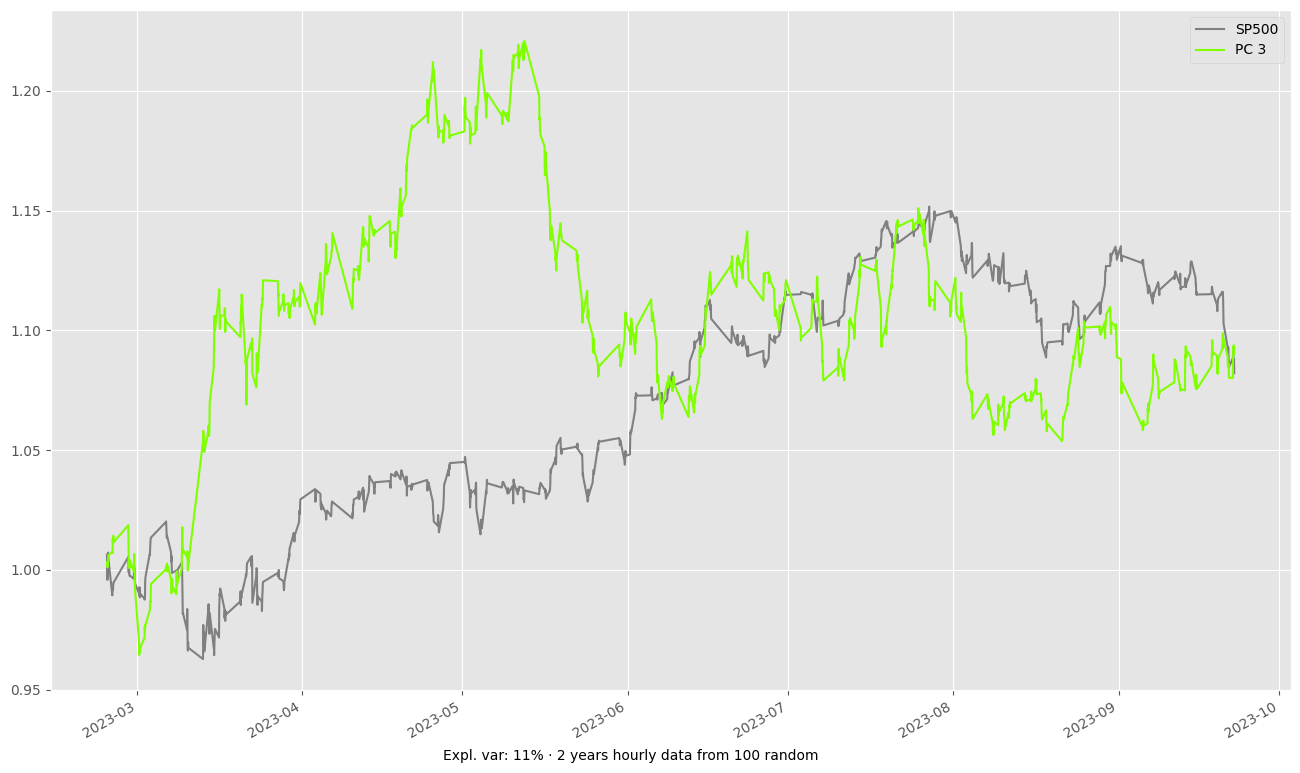

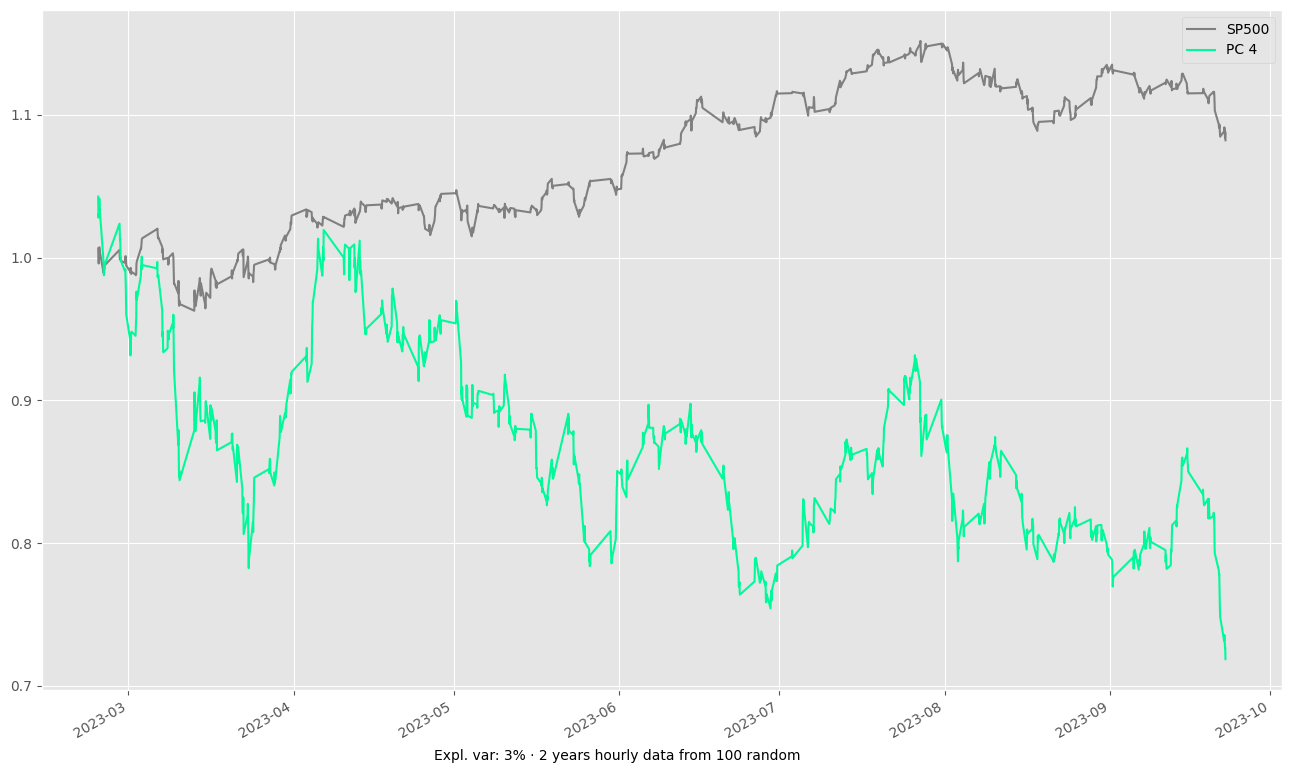

In [ ]:
# Returns of the first principal portfolio compared to SP500
returns_test_pp1 = returns_test_pc['PC ' + str(1)]
ax = pd.DataFrame(np.cumprod(benchmark_test+1)).plot(color='grey')
pd.DataFrame(np.cumprod(returns_test_pp1+1)).plot(ax=ax, figsize = (16,10), color=col[0], xlabel='', \
                              title="Performance of the individual principal portfolios")
plt.figtext(0.37, 0.13, "Expl. var: "+str(round(expl_var[0]*100))+"%"+" · "+t_hor+" "+t_freq+\
            " data from "+sampl)

# And of two more
returns_test_pp2 = returns_test_pc['PC ' + str(2)]
ax2 = pd.DataFrame(np.cumprod(benchmark_test+1)).plot(color='grey')
pd.DataFrame(np.cumprod(returns_test_pp2+1)).plot(ax=ax2, figsize = (16,10), color=col[1], xlabel='')
plt.figtext(0.37, 0.13, "Expl. var: "+str(round(expl_var[1]*100))+"%"+" · "+t_hor+" "+t_freq+\
            " data from "+sampl)

if returns_test_pc.shape[1] > 2:
  returns_test_pp3 = returns_test_pc['PC ' + str(3)]
  ax3 = pd.DataFrame(np.cumprod(benchmark_test+1)).plot(color='grey')
  pd.DataFrame(np.cumprod(returns_test_pp3+1)).plot(ax=ax3, figsize = (16,10), color=col[2], xlabel='')
  plt.figtext(0.37, 0.13, "Expl. var: "+str(round(expl_var[2]*100))+"%"+" · "+t_hor+" "+t_freq+\
              " data from "+sampl)

# And maybe two more (not very useful)
if returns_test_pc.shape[1] > 3:
  returns_test_pp4 = returns_test_pc['PC ' + str(4)]
  ax4 = pd.DataFrame(np.cumprod(benchmark_test+1)).plot(color='grey')
  pd.DataFrame(np.cumprod(returns_test_pp4+1)).plot(ax=ax4, figsize = (16,10), color=col[3], xlabel='')
  plt.figtext(0.37, 0.13, "Expl. var: "+str(round(expl_var[3]*100))+"%"+" · "+t_hor+" "+t_freq+\
              " data from "+sampl)

  if returns_test_pc.shape[1] > 4:
    returns_test_pp5 = returns_test_pc['PC ' + str(5)]
    ax5 = pd.DataFrame(np.cumprod(benchmark_test+1)).plot(color='grey')
    pd.DataFrame(np.cumprod(returns_test_pp5+1)).plot(ax=ax5, figsize = (16,10), color=col[4], xlabel='')
    plt.figtext(0.35, 0.13, "Expl. var: "+str(round(expl_var[4],2)*100)+"%"+" · "+t_hor+" "+t_freq+\
                " data from "+sampl)

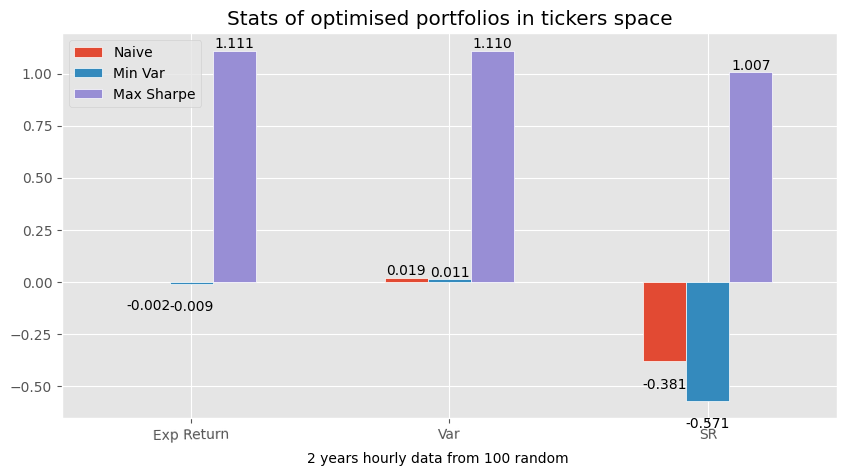

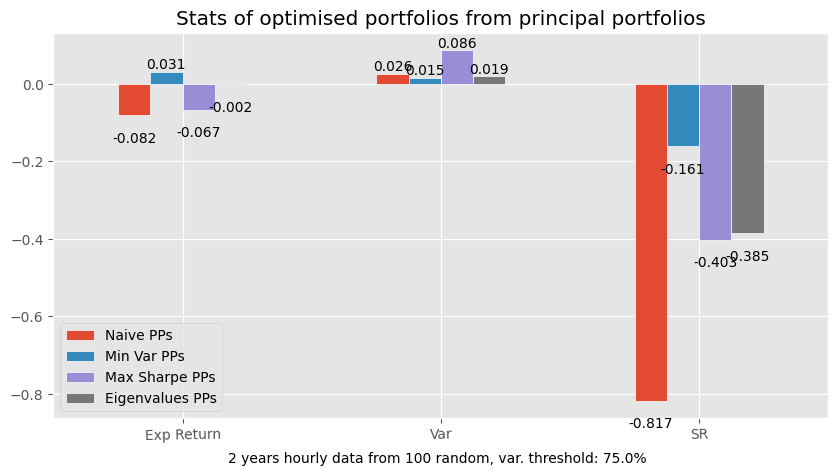

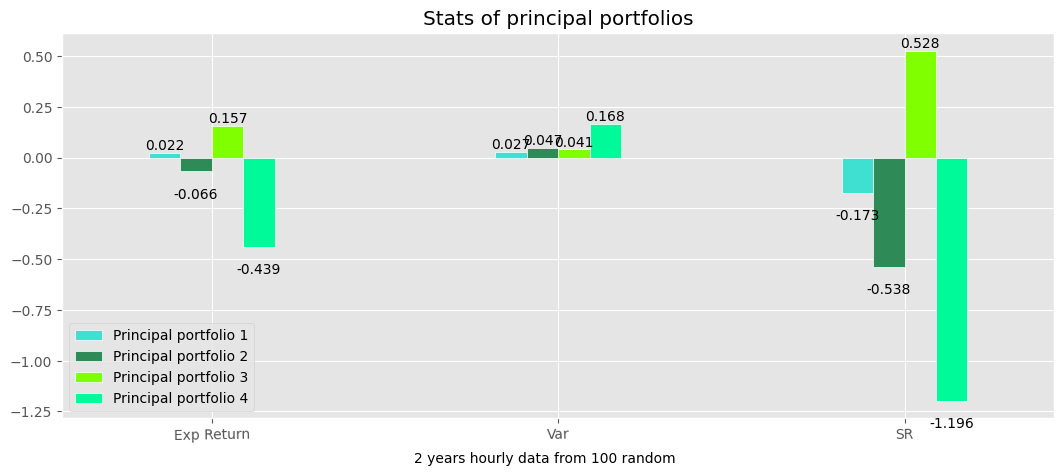

In [ ]:
# Moments from original space
mu_training, cov_training = getMoments(prices_training)
mu_test, cov_test = getMoments(prices_test)
rf_test = rf_series_test.to_numpy().mean()

# Moments from PCs space
mu_training_pc, cov_training_pc = getMoments_returns_ann(returns_training_pc)
mu_test_pc, cov_test_pc = getMoments_returns_ann(returns_test_pc)

# Weights of tickers' space portfolios
N = len(tickers2)
w_naive = np.ones(shape=(1,N)) / N
w_minVar_training = optPortNum(cov_training)
w_MaxSharpe_training = optPortNum(cov_training, mu_training, 2, False)
w_MaxSharpe_training /= w_MaxSharpe_training.sum()

# Weights of PCs space portfolios
w_naive_pc = np.ones(shape=(1,n_components)) / n_components
w_minVar_training_pc = optPortNum(cov_training_pc)
w_MaxSharpe_training_pc = optPortNum(cov_training_pc, mu_training_pc, 2, False)
w_MaxSharpe_training_pc /= w_MaxSharpe_training_pc.sum()

summ = expl_var.sum(axis=0)
w_proportional_pc = expl_var / summ

# Portfolios generated in the tickers' space
w_naive_statsOOS = ptf_stats(w_naive[0], mu_test, cov_test, rf_test)
w_minVar_statsOOS = ptf_stats(w_minVar_training, mu_test, cov_test, rf_test)
w_MaxSharpe_statsOSS = ptf_stats(w_MaxSharpe_training, mu_test, cov_test, rf_test)

# Portfolios generated from optimization of principal portfolios
w_naive_stats_pc_OOS = ptf_stats(w_naive_pc[0], mu_test_pc, cov_test_pc, rf_test)
w_minVar_stats_pc_OOS = ptf_stats(w_minVar_training_pc, mu_test_pc, cov_test_pc, rf_test)
w_MaxSharpe_stats_pc_OSS = ptf_stats(w_MaxSharpe_training_pc, mu_test_pc, cov_test_pc, rf_test)

w_proportional_pc_OSS = ptf_stats(w_proportional_pc, mu_test_pc, cov_test_pc, rf_test)

# Performance of the principal portfolios
w_pc_asis_stats_dict = {}
for x in range(0, w_pc.shape[1]):
  w_pc_asis_stats_dict["Principal portfolio {0}".format(x+1)] = ptf_stats(w_pc.iloc[:,x], \
                                                                          mu_test, cov_test, rf_test)

stats = pd.DataFrame([w_naive_statsOOS, w_minVar_statsOOS, w_MaxSharpe_statsOSS],\
                    columns = ['Exp Return', 'Var', 'SR'],
                    index = ['Naive','Min Var','Max Sharpe'])
p1 = (stats.T).plot.bar(figsize = (10,5), edgecolor='white', \
                        title='Stats of optimised portfolios in tickers space')
plt.figtext(0.37, 0.02, t_hor+" "+t_freq+" data from "+sampl)
plt.xticks(rotation = 1)

for container in p1.containers:
    p1.bar_label(container, fmt='\n%.3f')

stats_pc = pd.DataFrame([w_naive_stats_pc_OOS, w_minVar_stats_pc_OOS, w_MaxSharpe_stats_pc_OSS, w_proportional_pc_OSS],\
                    columns = ['Exp Return', 'Var', 'SR'],
                    index = ['Naive PPs','Min Var PPs','Max Sharpe PPs',"Eigenvalues PPs"])
p2 = (stats_pc.T).plot.bar(figsize = (10,5), edgecolor='white', \
                           title='Stats of optimised portfolios from principal portfolios')
plt.figtext(0.3, 0.02, t_hor+" "+t_freq+" data from "+sampl+", var. threshold: "+str(var_threshold*100)+"%")
plt.xticks(rotation = 1)

for container in p2.containers:
    p2.bar_label(container, fmt='\n%.3f')

stats_pc_asis = pd.DataFrame(w_pc_asis_stats_dict, index=['Exp Return', 'Var', 'SR']).T

p3 = (stats_pc_asis.T).plot.bar(figsize = (10+stats_pc_asis.shape[0]*0.7,5), \
                                edgecolor='white', color=col, \
                                title='Stats of principal portfolios', width=stats_pc_asis.shape[0]/11)
plt.figtext(0.4, 0.02, t_hor+" "+t_freq+" data from "+sampl)
plt.xticks(rotation = 1)

for container in p3.containers:
    p3.bar_label(container, fmt='\n%.3f')



In [ ]:
cnames = {
'aqua':                 '#00FFFF',
'aquamarine':           '#7FFFD4',
'bisque':               '#FFE4C4',
'blue':                 '#0000FF',
'blueviolet':           '#8A2BE2',
'cadetblue':            '#5F9EA0',
'chartreuse':           '#7FFF00',
'coral':                '#FF7F50',
'cornflowerblue':       '#6495ED',
'crimson':              '#DC143C',
'cyan':                 '#00FFFF',
'darkblue':             '#00008B',
'darkcyan':             '#008B8B',
'darkgoldenrod':        '#B8860B',
'darkgreen':            '#006400',
'darkmagenta':          '#8B008B',
'darkorange':           '#FF8C00',
'darkorchid':           '#9932CC',
'darkred':              '#8B0000',
'darksalmon':           '#E9967A',
'darkseagreen':         '#8FBC8F',
'darkslateblue':        '#483D8B',
'darkturquoise':        '#00CED1',
'darkviolet':           '#9400D3',
'deeppink':             '#FF1493',
'deepskyblue':          '#00BFFF',
'dodgerblue':           '#1E90FF',
'firebrick':            '#B22222',
'forestgreen':          '#228B22',
'fuchsia':              '#FF00FF',
'gold':                 '#FFD700',
'goldenrod':            '#DAA520',
'green':                '#008000',
'greenyellow':          '#ADFF2F',
'hotpink':              '#FF69B4',
'indianred':            '#CD5C5C',
'indigo':               '#4B0082',
'lightblue':            '#ADD8E6',
'lightcoral':           '#F08080',
'lightgreen':           '#90EE90',
'lightpink':            '#FFB6C1',
'lightsalmon':          '#FFA07A',
'lightseagreen':        '#20B2AA',
'lightskyblue':         '#87CEFA',
'lightsteelblue':       '#B0C4DE',
'lime':                 '#00FF00',
'limegreen':            '#32CD32',
'magenta':              '#FF00FF',
'mediumaquamarine':     '#66CDAA',
'mediumblue':           '#0000CD',
'mediumorchid':         '#BA55D3',
'mediumpurple':         '#9370DB',
'mediumseagreen':       '#3CB371',
'mediumslateblue':      '#7B68EE',
'mediumspringgreen':    '#00FA9A',
'mediumturquoise':      '#48D1CC',
'mediumvioletred':      '#C71585',
'midnightblue':         '#191970',
'navy':                 '#000080',
'olive':                '#808000',
'olivedrab':            '#6B8E23',
'orange':               '#FFA500',
'orangered':            '#FF4500',
'orchid':               '#DA70D6',
'palegoldenrod':        '#EEE8AA',
'palegreen':            '#98FB98',
'palevioletred':        '#DB7093',
'peachpuff':            '#FFDAB9',
'peru':                 '#CD853F',
'pink':                 '#FFC0CB',
'plum':                 '#DDA0DD',
'powderblue':           '#B0E0E6',
'purple':               '#800080',
'red':                  '#FF0000',
'royalblue':            '#4169E1',
'salmon':               '#FA8072',
'seagreen':             '#2E8B57',
'sienna':               '#A0522D',
'skyblue':              '#87CEEB',
'slateblue':            '#6A5ACD',
'springgreen':          '#00FF7F',
'steelblue':            '#4682B4',
'teal':                 '#008080',
'tomato':               '#FF6347',
'turquoise':            '#40E0D0',
'violet':               '#EE82EE',
'wheat':                '#F5DEB3',
'yellowgreen':          '#9ACD32'}